In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_columns', 100)
set_config(display='diagram', transform_output='pandas')

# Data Acquisition

In [2]:
titanic_data = pd.read_csv('../data/train.csv')
titanic_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


#  Data Quality Check

In [3]:
titanic_data.shape

(891, 12)

In [4]:
titanic_data.dtypes.value_counts()

int64      5
object     5
float64    2
Name: count, dtype: int64

In [5]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
titanic_data.isnull().sum().loc[titanic_data.isnull().sum() > 0]

Age         177
Cabin       687
Embarked      2
dtype: int64

In [7]:
titanic_data.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [8]:
titanic_data['Cabin'].value_counts()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

In [9]:
titanic_data.select_dtypes(include='number').var()

PassengerId    66231.000000
Survived           0.236772
Pclass             0.699015
Age              211.019125
SibSp              1.216043
Parch              0.649728
Fare            2469.436846
dtype: float64

In [10]:
titanic_data.select_dtypes(include=object).nunique()

Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64

In [11]:
(titanic_data.nunique() / titanic_data.shape[0] * 100).round(2)

PassengerId    100.00
Survived         0.22
Pclass           0.34
Name           100.00
Sex              0.22
Age              9.88
SibSp            0.79
Parch            0.79
Ticket          76.43
Fare            27.83
Cabin           16.50
Embarked         0.34
dtype: float64

In [12]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Data Cleaning

In [13]:
titanic_data['Age'] = np.round(KNNImputer(weights='distance').fit_transform(titanic_data[['Age']]).values).flatten()
titanic_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,30.0,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [14]:
emb_mod = titanic_data['Embarked'].mode()[0]
titanic_data['Embarked'] = titanic_data['Embarked'].fillna(emb_mod)
titanic_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,30.0,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Exploratory Data Analysis

In [15]:
def hist_box_plot(columns):
    for col in columns:
        plt.figure(figsize=(13,4))
        plt.subplot(1,2,1)
        sns.histplot(titanic_data, x=col, kde=True)
        plt.title('Histogram')
        plt.subplot(1,2,2)
        sns.boxplot(titanic_data, x=col, width=.5)
        plt.title('Box Plot')
        plt.show

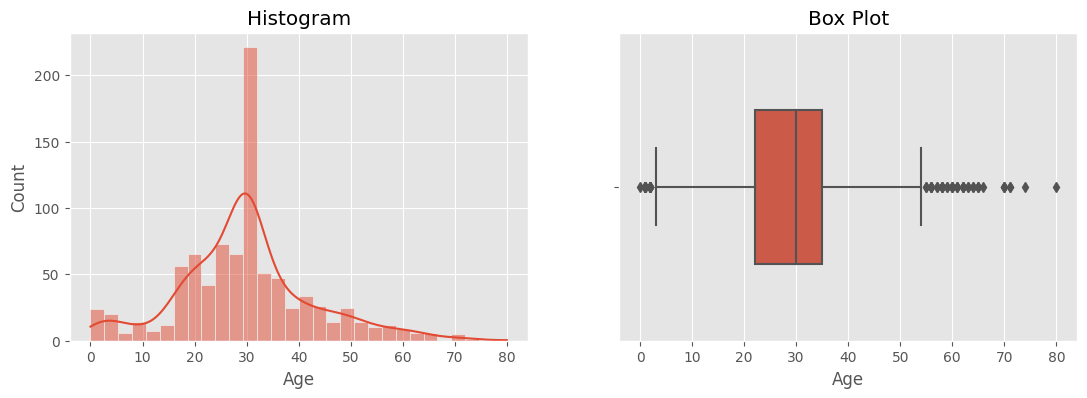

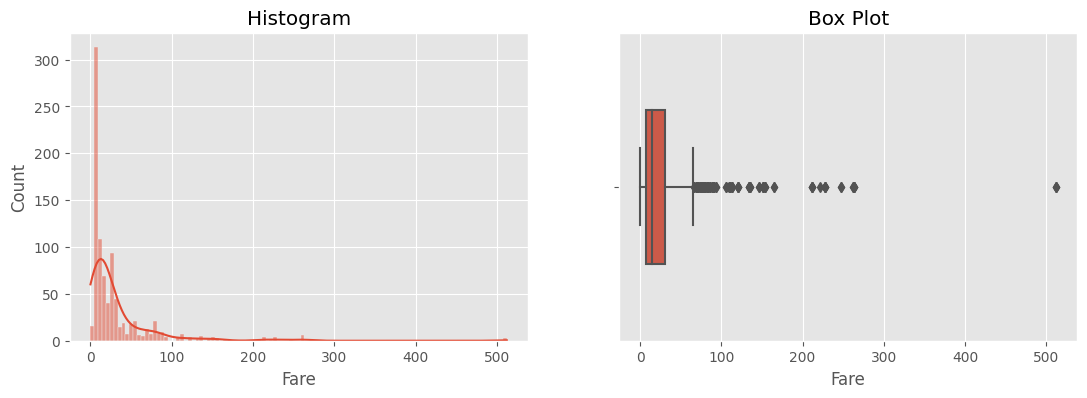

In [16]:
hist_box_plot(titanic_data.select_dtypes('float').columns)

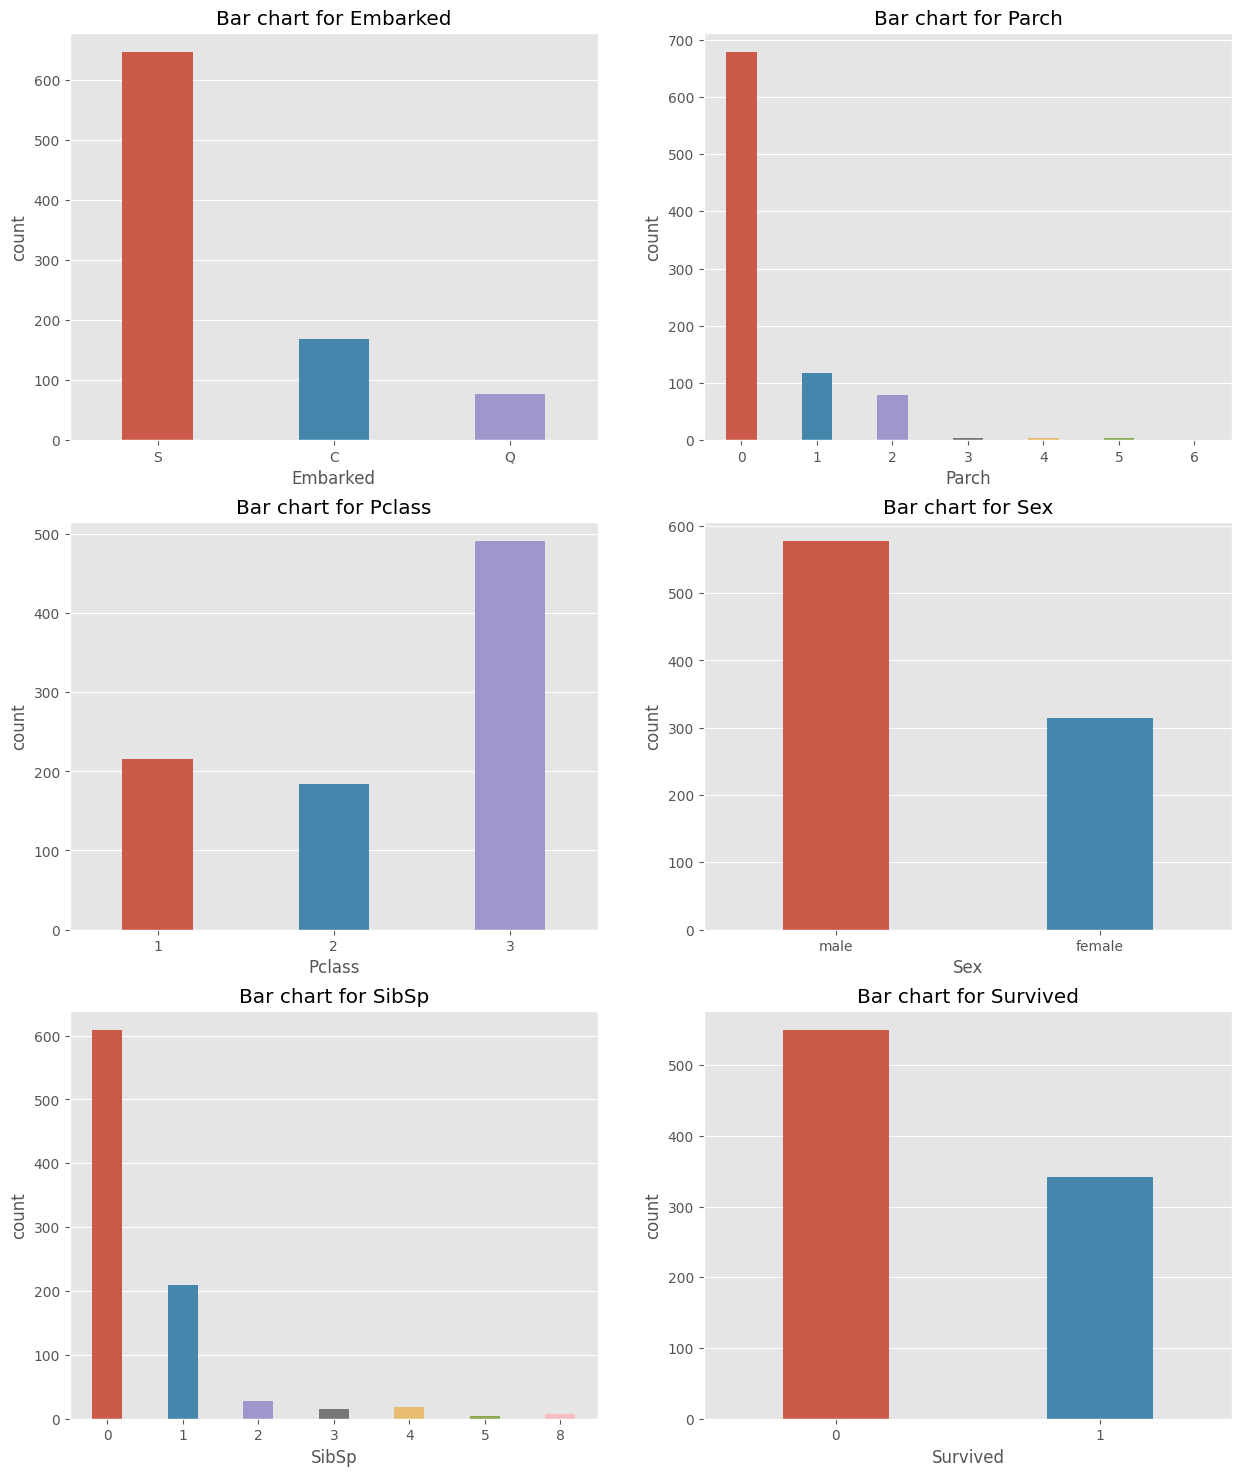

In [17]:
columns = titanic_data.select_dtypes(include=['int', 'object']).\
    columns.difference(['PassengerId', 'Name', 'Ticket', 'Cabin'])
l = len(columns) // 2 if len(columns) % 2 == 0 else len(columns) // 2 + 1
plt.figure(figsize=(15,l*6))
for i, col in enumerate(columns):
    plt.subplot(l,2,i+1)
    sns.countplot(titanic_data, x=col, width=0.4)
    plt.title(f'Bar chart for {col}')
plt.show()

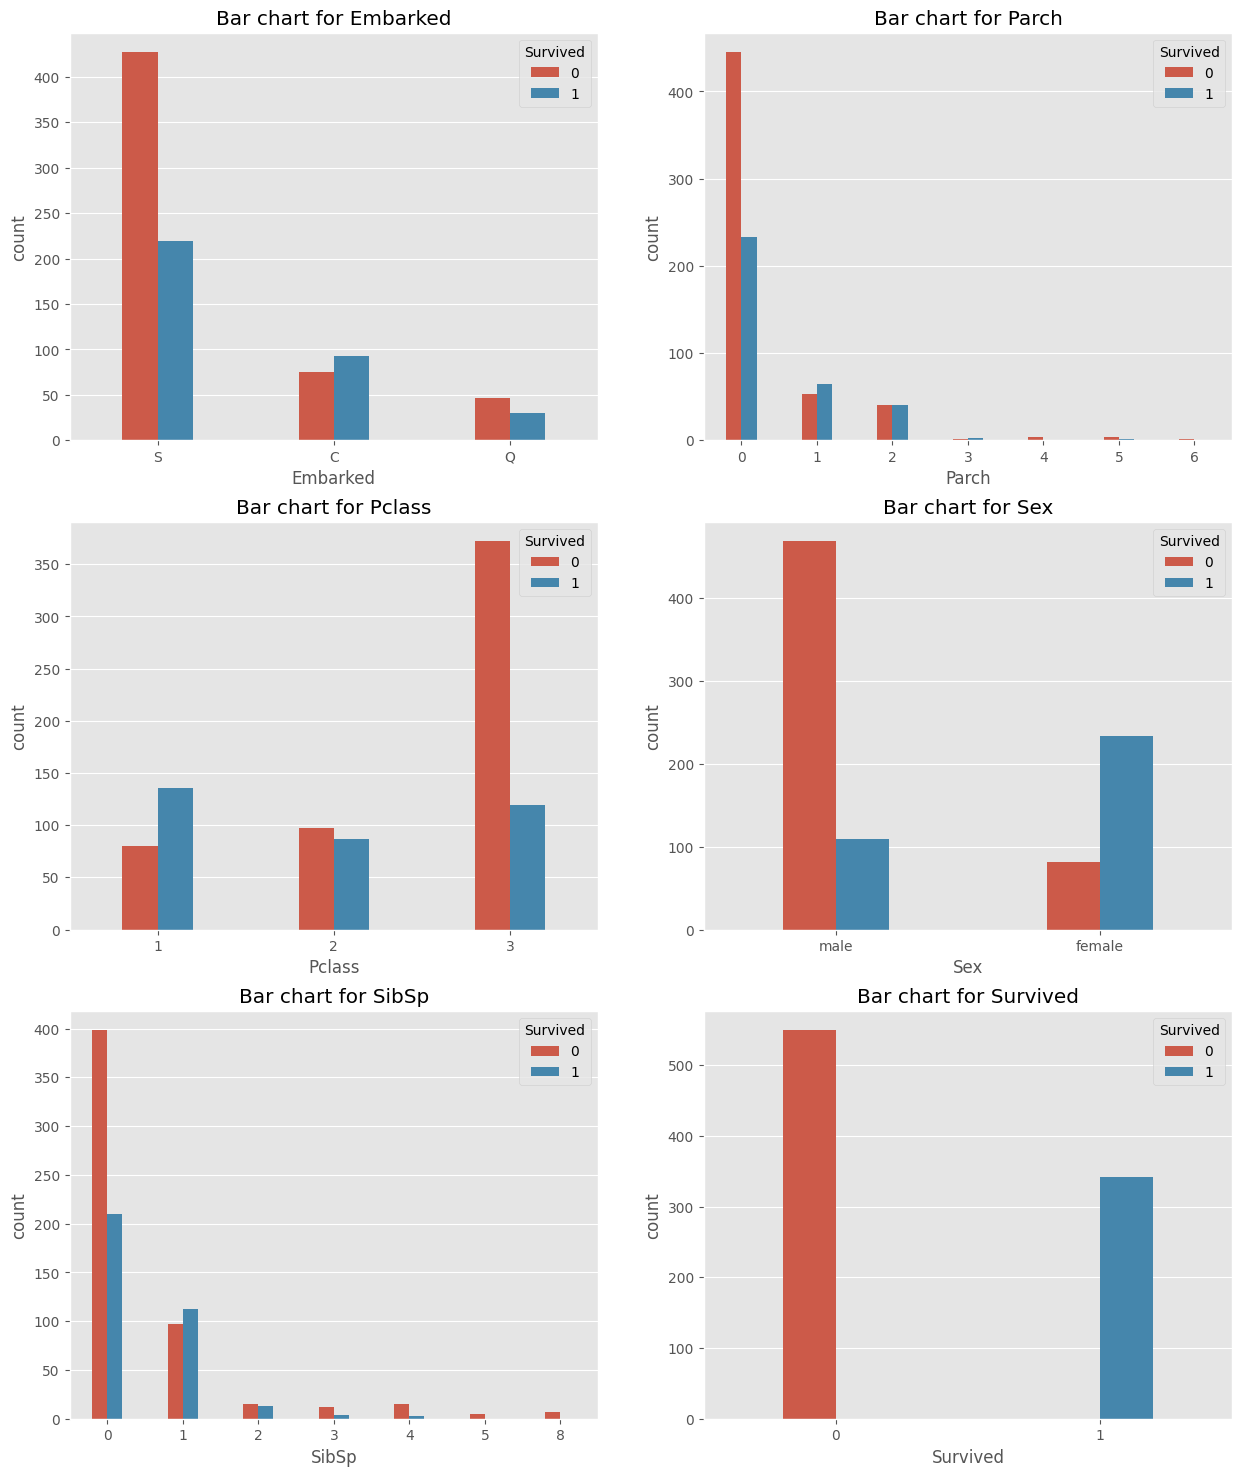

In [18]:
columns = titanic_data.select_dtypes(include=['int', 'object']).\
    columns.difference(['PassengerId', 'Name', 'Ticket', 'Cabin'])
l = len(columns) // 2 if len(columns) % 2 == 0 else len(columns) // 2 + 1
plt.figure(figsize=(15,l*6))
for i, col in enumerate(columns):
    plt.subplot(l,2,i+1)
    sns.countplot(titanic_data, x=col, width=0.4, hue='Survived')
    plt.title(f'Bar chart for {col}')
plt.show()

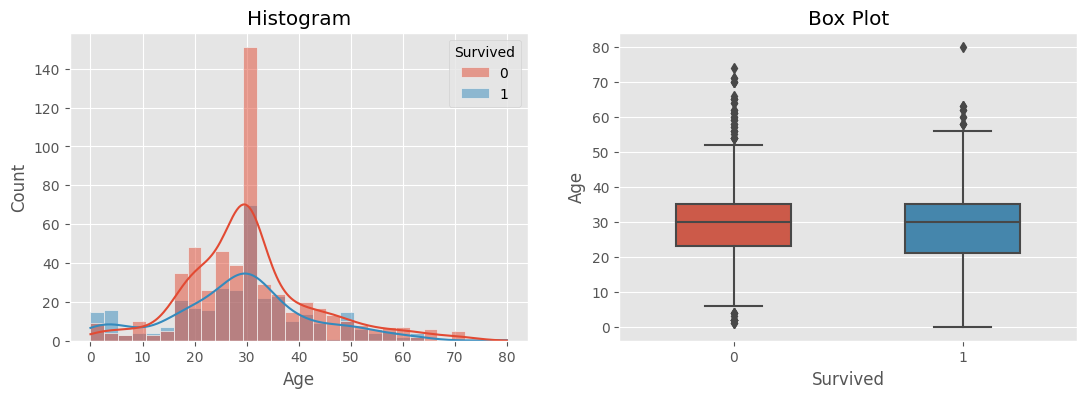

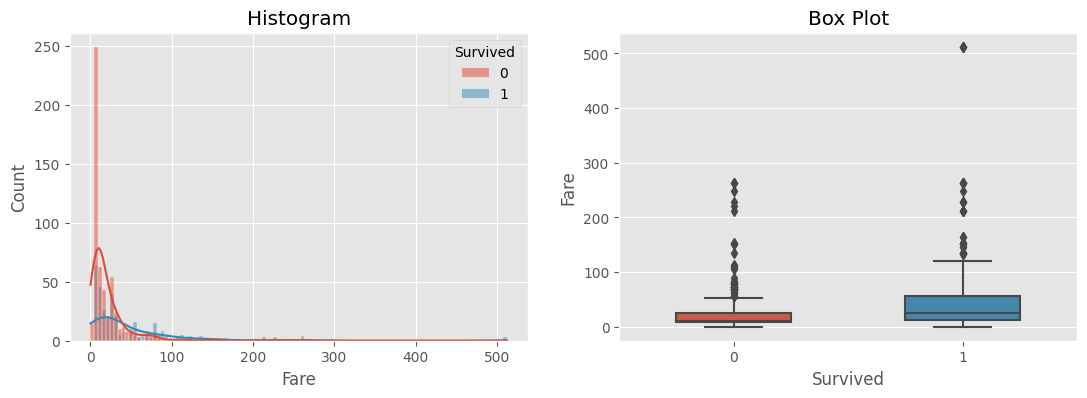

In [19]:
columns = titanic_data.select_dtypes('float').columns
for col in columns:
    plt.figure(figsize=(13,4))
    plt.subplot(1,2,1)
    sns.histplot(titanic_data, x=col, kde=True, hue='Survived')
    plt.title('Histogram')
    plt.subplot(1,2,2)
    sns.boxplot(titanic_data, x='Survived', y=col, width=.5)
    plt.title('Box Plot')
    plt.show
    


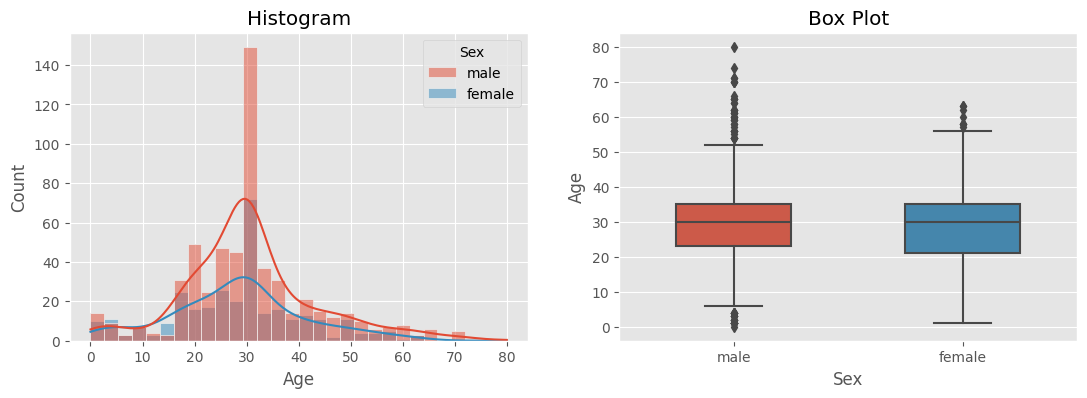

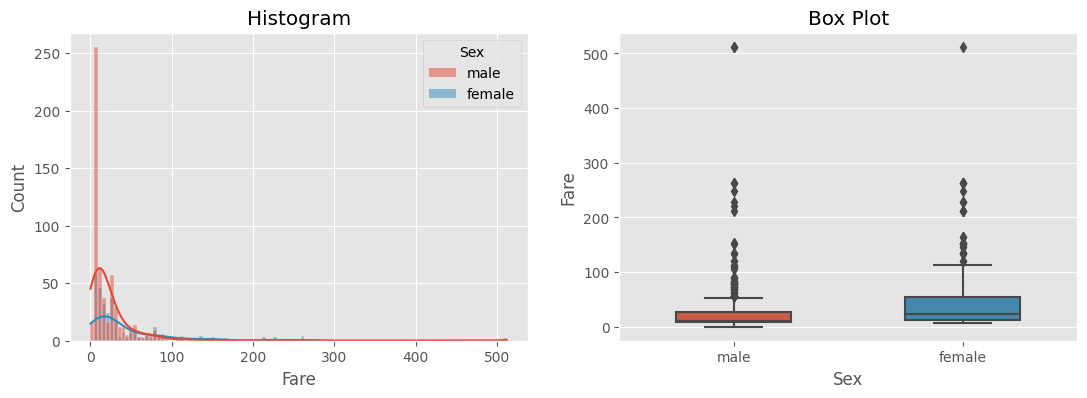

In [20]:
columns = titanic_data.select_dtypes('float').columns
for col in columns:
    plt.figure(figsize=(13,4))
    plt.subplot(1,2,1)
    sns.histplot(titanic_data, x=col, kde=True, hue='Sex')
    plt.title('Histogram')
    plt.subplot(1,2,2)
    sns.boxplot(titanic_data, x='Sex', y=col, width=.5)
    plt.title('Box Plot')
    plt.show
    


# Feature Engineering

In [21]:
titanic_data['title'] = titanic_data['Name'].str.extract(r',\s([A-Za-z]+)')
titanic_data.drop(columns=['PassengerId', 'Name'], inplace=True)
titanic_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,211536,13.0000,NaN,S,Rev
887,1,1,female,19.0,0,0,112053,30.0000,B42,S,Miss
888,0,3,female,30.0,1,2,W./C. 6607,23.4500,NaN,S,Miss
889,1,1,male,26.0,0,0,111369,30.0000,C148,C,Mr


In [22]:
titanic_data['Cabin'] = np.where(titanic_data['Cabin'].isna(), 0, 1)
titanic_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
0,0,3,male,22.0,1,0,A/5 21171,7.2500,0,S,Mr
1,1,1,female,38.0,1,0,PC 17599,71.2833,1,C,Mrs
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,Miss
3,1,1,female,35.0,1,0,113803,53.1000,1,S,Mrs
4,0,3,male,35.0,0,0,373450,8.0500,0,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,211536,13.0000,0,S,Rev
887,1,1,female,19.0,0,0,112053,30.0000,1,S,Miss
888,0,3,female,30.0,1,2,W./C. 6607,23.4500,0,S,Miss
889,1,1,male,26.0,0,0,111369,30.0000,1,C,Mr


In [23]:
titanic_data['Ticket_series'] = titanic_data['Ticket'].str.extract(r'(^\D+[0-9])')
titanic_data['Ticket_series'] = np.where(titanic_data['Ticket_series'].isna(), 0, 1)
titanic_data.drop(columns=['Ticket'], inplace=True)
titanic_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,title,Ticket_series
0,0,3,male,22.0,1,0,7.2500,0,S,Mr,1
1,1,1,female,38.0,1,0,71.2833,1,C,Mrs,1
2,1,3,female,26.0,0,0,7.9250,0,S,Miss,1
3,1,1,female,35.0,1,0,53.1000,1,S,Mrs,0
4,0,3,male,35.0,0,0,8.0500,0,S,Mr,0
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,0,S,Rev,0
887,1,1,female,19.0,0,0,30.0000,1,S,Miss,0
888,0,3,female,30.0,1,2,23.4500,0,S,Miss,1
889,1,1,male,26.0,0,0,30.0000,1,C,Mr,0


# Feature Selection

In [24]:
fs_data = titanic_data.copy()
fs_data_ec = OrdinalEncoder().fit_transform(fs_data)
X = fs_data_ec.drop(columns=['Survived'])
y = fs_data_ec.loc[:, 'Survived']

In [25]:
skb = SelectKBest(f_classif, k='all')
skb.fit(X, y)
pd.DataFrame({'features': skb.feature_names_in_, 
              'scores': skb.scores_, 
              'dependent': skb.pvalues_ < 0.05}).\
                sort_values(by=['scores'], ascending=False)

,features,scores,dependent
1,Sex,372.405724,True
0,Pclass,115.031272,True
5,Fare,111.583030,True
6,Cabin,99.253142,True
8,title,34.631135,True
7,Embarked,25.717286,True
4,Parch,5.963464,True
2,Age,4.458827,True
3,SibSp,0.619322,False
9,Ticket_series,0.001595,False


In [26]:
rfe = RFE(RidgeClassifier())
rfe.fit(X, y)
pd.DataFrame({'features': rfe.feature_names_in_, 
              'ranking': rfe.ranking_}).\
                sort_values(by=['ranking'])

,features,ranking
0,Pclass,1
1,Sex,1
3,SibSp,1
6,Cabin,1
7,Embarked,1
8,title,2
4,Parch,3
2,Age,4
9,Ticket_series,5
5,Fare,6


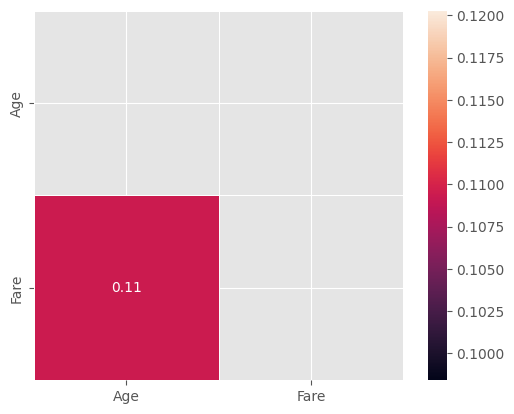

In [27]:
# plt.figure(figsize=(15,12))
mask = np.triu(np.ones(X[['Age', 'Fare']].corr().shape), k=0)
sns.heatmap(X[['Age', 'Fare']].corr(), annot=True, lw=0.5, square=True, mask=mask);

In [28]:
[(col, vif(X, i)) for i, col in enumerate(X.columns)]

[('Pclass', 8.767655769890133),
 ('Sex', 3.333521433570868),
 ('Age', 7.897958562651178),
 ('SibSp', 2.1591799277663424),
 ('Parch', 1.782545518127851),
 ('Fare', 9.459289939127988),
 ('Cabin', 2.6183433425794527),
 ('Embarked', 4.832821839000161),
 ('title', 27.46813830014657),
 ('Ticket_series', 1.3825834817602205)]

In [29]:
rc = RidgeClassifier(positive=True)
rc.fit(X, y)
pd.DataFrame({'features': rc.feature_names_in_, 
              'score': rc.coef_.flatten()})

,features,score
0,Pclass,0.000000
1,Sex,0.000000
2,Age,0.000000
3,SibSp,0.000000
4,Parch,0.000007
5,Fare,0.004637
6,Cabin,0.000037
7,Embarked,0.000000
8,title,0.000000
9,Ticket_series,0.000000


# Splitting the data

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Model Selection

In [34]:
models = [LogisticRegression(max_iter=1000), RidgeClassifier(), RandomForestClassifier(), 
          SVC(), BernoulliNB(), KNeighborsClassifier(), CatBoostClassifier()]
model_names = [x.__class__.__name__ for x in models]
score_list = list()
for model in models:
    pipe = make_pipeline(StandardScaler(), model)
    scores = cross_validate(pipe, X_train, y_train, scoring=['accuracy'], return_train_score=True)
    train_score = scores['train_accuracy'].mean()
    test_score = scores['test_accuracy'].mean()
    score_list.append((train_score, test_score))

pd.DataFrame({'model': model_names, 'train_accuracy': [x[0] for x in score_list], 'test_accuracy': [x[1] for x in score_list]})

Learning rate set to 0.008098
0:	learn: 0.6880248	total: 167ms	remaining: 2m 46s
1:	learn: 0.6815847	total: 170ms	remaining: 1m 24s
2:	learn: 0.6771150	total: 172ms	remaining: 57.3s
3:	learn: 0.6707533	total: 174ms	remaining: 43.4s
4:	learn: 0.6650343	total: 176ms	remaining: 35s
5:	learn: 0.6588196	total: 178ms	remaining: 29.5s
6:	learn: 0.6533699	total: 180ms	remaining: 25.5s
7:	learn: 0.6477418	total: 182ms	remaining: 22.6s
8:	learn: 0.6429898	total: 184ms	remaining: 20.3s
9:	learn: 0.6373422	total: 187ms	remaining: 18.5s
10:	learn: 0.6319978	total: 189ms	remaining: 17s
11:	learn: 0.6272960	total: 190ms	remaining: 15.7s
12:	learn: 0.6223789	total: 192ms	remaining: 14.6s
13:	learn: 0.6180307	total: 194ms	remaining: 13.7s
14:	learn: 0.6128893	total: 196ms	remaining: 12.9s
15:	learn: 0.6084032	total: 198ms	remaining: 12.2s
16:	learn: 0.6038536	total: 200ms	remaining: 11.6s
17:	learn: 0.5989544	total: 203ms	remaining: 11.1s
18:	learn: 0.5946500	total: 205ms	remaining: 10.6s
19:	learn: 0.

,model,train_accuracy,test_accuracy
0,LogisticRegression,0.801620,0.803447
1,RidgeClassifier,0.803376,0.803477
2,RandomForestClassifier,0.990523,0.787935
3,SVC,0.856391,0.823097
4,BernoulliNB,0.772126,0.771161
5,KNeighborsClassifier,0.859205,0.796395
6,CatBoostClassifier,0.920650,0.820250


In [38]:
from sklearn.ensemble import VotingClassifier

estimators = [
    ('svc', make_pipeline(StandardScaler(), SVC(C=1))),
    # ('logit', make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))),
    # ('knn', make_pipeline( CatBoostClassifier())),
    # ('rfc', make_pipeline(StandardScaler(), BernoulliNB())),
]
v_clf = VotingClassifier(estimators=estimators, n_jobs=-1)
scores = cross_validate(v_clf, X_train, y_train, scoring=['accuracy', 'recall', 'precision'], return_train_score=True, n_jobs=-1)

scores['train_accuracy'].mean().round(3), scores['test_accuracy'].mean().round(3)

(0.856, 0.823)

In [ ]:
scores['train_accuracy'].mean().round(2), scores['test_accuracy'].mean().round(2)

(0.84, 0.81)

In [39]:
scores

{'fit_time': array([0.03364491, 0.03313112, 0.03510237, 0.04066014, 0.03313112]),
 'score_time': array([0.01906419, 0.01454043, 0.016083  , 0.01407576, 0.01554227]),
 'test_accuracy': array([0.74825175, 0.85314685, 0.82394366, 0.82394366, 0.86619718]),
 'train_accuracy': array([0.8629174 , 0.85061511, 0.85263158, 0.86666667, 0.84912281]),
 'test_recall': array([0.58181818, 0.76363636, 0.7037037 , 0.85185185, 0.78181818]),
 'train_recall': array([0.81192661, 0.79357798, 0.78538813, 0.78995434, 0.75229358]),
 'test_precision': array([0.71111111, 0.84      , 0.80851064, 0.73015873, 0.86      ]),
 'train_precision': array([0.8271028 , 0.81220657, 0.82296651, 0.85221675, 0.83673469])}

In [33]:
from catboost import CatBoostClassifier

In [275]:
bins=[0, 10, 20, 40, 60, titanic_data['Age'].max()]
labels=['child', 'young', 'adult', 'old', 'very old']
pd.cut(titanic_data['Age'], bins=bins, labels=labels).astype('object')

0      adult
1      adult
2      adult
3      adult
4      adult
       ...  
886    adult
887    young
888      NaN
889    adult
890    adult
Name: Age, Length: 891, dtype: object

In [148]:
titanic_data['cabin_exist'] = np.where(titanic_data['Cabin'].isnull(), 0, 1)
titanic_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,cabin_exist
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1


In [40]:
titanic_data.nunique().loc[titanic_data.nunique() == titanic_data.shape[0]]

PassengerId    891
Name           891
dtype: int64

In [38]:
titanic_data.select_dtypes(include=object)

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S
...,...,...,...,...,...
886,"Montvila, Rev. Juozas",male,211536,NaN,S
887,"Graham, Miss. Margaret Edith",female,112053,B42,S
888,"Johnston, Miss. Catherine Helen ""Carrie""",female,W./C. 6607,NaN,S
889,"Behr, Mr. Karl Howell",male,111369,C148,C


In [43]:
titanic_data.columns = titanic_data.columns.str.lower()
titanic_data['name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: name, Length: 891, dtype: object

In [51]:
import re

fa = re.compile(r'([A-Za-z]+)\.')
titanic_data['name'].str.extract(fa).value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Mme           1
Ms            1
Capt          1
Lady          1
Jonkheer      1
Don           1
Countess      1
Sir           1
Name: count, dtype: int64

In [75]:
et = re.compile(r'([0-9][0-9]+)')
titanic_data['ticket'].str.split().map(lambda x: x[0] if len(x) > 1 else np.nan)

0           A/5
1            PC
2      STON/O2.
3           NaN
4           NaN
         ...   
886         NaN
887         NaN
888       W./C.
889         NaN
890         NaN
Name: ticket, Length: 891, dtype: object

In [68]:
titanic_data['ticket']

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: ticket, Length: 891, dtype: object

In [2]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'dowjones',
 'exercise',
 'flights',
 'fmri',
 'geyser',
 'glue',
 'healthexp',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'seaice',
 'taxis',
 'tips',
 'titanic',
 'anagrams',
 'anagrams',
 'anscombe',
 'anscombe',
 'attention',
 'attention',
 'brain_networks',
 'brain_networks',
 'car_crashes',
 'car_crashes',
 'diamonds',
 'diamonds',
 'dots',
 'dots',
 'dowjones',
 'dowjones',
 'exercise',
 'exercise',
 'flights',
 'flights',
 'fmri',
 'fmri',
 'geyser',
 'geyser',
 'glue',
 'glue',
 'healthexp',
 'healthexp',
 'iris',
 'iris',
 'mpg',
 'mpg',
 'penguins',
 'penguins',
 'planets',
 'planets',
 'seaice',
 'seaice',
 'taxis',
 'taxis',
 'tips',
 'tips',
 'titanic',
 'titanic',
 'anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'dowjones',
 'exercise',
 'flights',
 'fmri',
 'geyser',
 'glue',
 'healthexp',
 'iris',
 'mpg',
 'penguins',
 'plan

In [137]:
df_corr = sns.load_dataset('mpg').corr(numeric_only=True)
df_corr

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
mpg,1.000000,-0.775396,-0.804203,-0.778427,-0.831741,0.420289,0.579267
cylinders,-0.775396,1.000000,0.950721,0.842983,0.896017,-0.505419,-0.348746
displacement,-0.804203,0.950721,1.000000,0.897257,0.932824,-0.543684,-0.370164
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361
weight,-0.831741,0.896017,0.932824,0.864538,1.000000,-0.417457,-0.306564
acceleration,0.420289,-0.505419,-0.543684,-0.689196,-0.417457,1.000000,0.288137
model_year,0.579267,-0.348746,-0.370164,-0.416361,-0.306564,0.288137,1.000000


In [29]:
mapping = np.triu(np.ones(df_corr.shape), k=1).astype('bool')
df_corr.where(mapping)

,carat,depth,table,price,x,y,z
carat,NaN,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,NaN,NaN,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,NaN,NaN,NaN,0.127134,0.195344,0.183760,0.150929
price,NaN,NaN,NaN,NaN,0.884435,0.865421,0.861249
x,NaN,NaN,NaN,NaN,NaN,0.974701,0.970772
y,NaN,NaN,NaN,NaN,NaN,NaN,0.952006
z,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
df_corr_us = df_corr.where(mapping).unstack().reset_index().rename(columns={'level_0': 'var1', 'level_1': 'var2', 0: 'corr'})
df_corr_us

,var1,var2,corr
0,carat,carat,NaN
1,carat,depth,NaN
2,carat,table,NaN
3,carat,price,NaN
4,carat,x,NaN
5,carat,y,NaN
6,carat,z,NaN
7,depth,carat,0.028224
8,depth,depth,NaN
9,depth,table,NaN


In [37]:
df_corr_us_dp = df_corr_us.dropna()
df_corr_us_dp

,var1,var2,corr
7,depth,carat,0.028224
14,table,carat,0.181618
15,table,depth,-0.295779
21,price,carat,0.921591
22,price,depth,-0.010647
23,price,table,0.127134
28,x,carat,0.975094
29,x,depth,-0.025289
30,x,table,0.195344
31,x,price,0.884435


In [40]:
filt = df_corr_us_dp['corr'].abs().gt(0.8)
df_corr_us_dp.loc[filt]

,var1,var2,corr
21,price,carat,0.921591
28,x,carat,0.975094
31,x,price,0.884435
35,y,carat,0.951722
38,y,price,0.865421
39,y,x,0.974701
42,z,carat,0.953387
45,z,price,0.861249
46,z,x,0.970772
47,z,y,0.952006


In [47]:
df_corr_us_dp.loc[filt]['var1'].unique()

array(['price', 'x', 'y', 'z'], dtype=object)

In [43]:
df_corr_us_dp.loc[filt]['var2'].unique()

array(['carat', 'price', 'x', 'y'], dtype=object)

In [68]:
l1, l2 = set(), set()
for arr in df_corr_us_dp.loc[filt][['var1', 'var2']].values:
    if (arr[1] not in l1) & (arr[1] not in l2):
        l1.add(arr[0])
    l2.add(arr[1])
l1, l2

({'price', 'y'}, {'carat', 'price', 'x', 'y'})

In [72]:
df_corr_us_dp.loc[filt][['var1', 'var2']].stack().unique()

array(['price', 'carat', 'x', 'y', 'z'], dtype=object)

In [60]:
l1.add('lele1')

In [61]:
l1

{'c', 'e', 'i', 'lele', 'lele1', 'p', 'r', 'x', 'y', 'z'}

In [77]:
df_corr

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
mpg,1.000000,-0.775396,-0.804203,-0.778427,-0.831741,0.420289,0.579267
cylinders,-0.775396,1.000000,0.950721,0.842983,0.896017,-0.505419,-0.348746
displacement,-0.804203,0.950721,1.000000,0.897257,0.932824,-0.543684,-0.370164
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361
weight,-0.831741,0.896017,0.932824,0.864538,1.000000,-0.417457,-0.306564
acceleration,0.420289,-0.505419,-0.543684,-0.689196,-0.417457,1.000000,0.288137
model_year,0.579267,-0.348746,-0.370164,-0.416361,-0.306564,0.288137,1.000000
